In [2]:
import numpy as np
from math import *
import networkx as nx
import matplotlib.pyplot as plt
import igraph
import scipy
import scipy.linalg as la
import seaborn as sns
from matplotlib import patches
from random import randint
from numpy import linalg as LA

Finally, we compare the performance of the formerly described methods in the case of artificial and real world datasets.

We used Python, and specifically the classic libraries such as Numpy and Scipy. For the manipulation of graphs, we used networkX, and iGraph for the plots.

In [3]:
def WignerLaw(x, c):
    return ((sqrt(4*c - x**2))/(2*pi*c))

def plotEigenvalues(arr):
    sns.distplot(countVillage, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

def overlap2(listLabel):
    n = len(listLabel)
    trueLabel1 = np.array([1 for i in range(int(n/2))] + [-1 for i in range(int(n/2))])
    trueLabel2 = np.array([-1 for i in range(int(n/2))] + [1 for i in range(int(n/2))])
    l1 = (np.multiply(listLabel, trueLabel1) + 1)/2
    l2 = (np.multiply(listLabel, trueLabel2) + 1)/2
    return((max(np.sum(l1), np.sum(l2)))/n - 0.5)

def overlapGiven(listLabel, attribution):
    n = len(listLabel)
    trueLabel1 = np.array([-el for el in listLabel])
    trueLabel2 = np.array([el for el in listLabel])
    l1 = (np.multiply(attribution, trueLabel1) + 1)/2
    l2 = (np.multiply(attribution, trueLabel2) + 1)/2
    return((max(np.sum(l1), np.sum(l2)))/n - max(np.mean((trueLabel2 + 1)/2), np.mean((trueLabel1 + 1)/2)))

def arrayToSign(arr):
    lResult = []
    for el in arr:
        if el > 0:
            lResult.append(1)
        elif el < 0:
            lResult.append(-1)
        else :
            lResult.append(2*randint(0,1) - 1)
    return(np.array(lResult))

In [74]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3
#G = NetworkX Graph
def computeNonBackTracking(G):
    lEdges = list(G.edges())
    m = len(lEdges)
    B = np.zeros((2*m,2*m))
    for i in range(m):
        for j in range(i+1, m):
            couplei = lEdges[i]
            couplej = lEdges[j]
            if len(intersection(list(couplei), list(couplej))) == 1:
                if couplei[1] == couplej[0]:
                    B[2*i,2*j] = 1
                    B[2*j + 1,2*i + 1] = 1
                elif couplei[1] == couplej[1]:
                    B[2*i,2*j+1] = 1
                    B[2*j, 2*i + 1] = 1
                elif couplei[0] == couplej[0]:
                    B[2*i+1,2*j] = 1
                    B[2*j + 1, 2*i] = 1
                else :
                    B[2*i+1,2*j+1] = 1
                    B[2*j, 2*i] = 1
    return(scipy.sparse.csr_matrix(B))

def computeBPrime(G):
    n = len(G)
    z = np.zeros((n,n))
    o = np.eye(n)
    D = np.diag([el[1] for el in G.degree])
    A = scipy.sparse.csr_matrix.toarray(nx.adjacency_matrix(G))
    mat = np.concatenate((np.concatenate((z,D - o),axis=1), np.concatenate((-o,A), axis = 1)))
    return(mat)

def computeFlow(G):
    ## Work Out the Flow matrix
    lEdges = list(G.edges())
    m = len(lEdges)
    degree = dict(G.degree())
    B = scipy.sparse.lil_matrix((2*m,2*m))
    D = scipy.sparse.lil_matrix((2*m,2*m))
    for i in range(m):
        couplei = lEdges[i]
        if degree[couplei[1]] > 1:
            D[2*i, 2*i] = 1/(degree[couplei[1]] - 1)
        if degree[couplei[0]] > 1:
            D[2*i + 1, 2*i + 1] = 1/(degree[couplei[0]] - 1)
        for j in range(i+1, m):
            couplej = lEdges[j]
            if len(intersection(list(couplei), list(couplej))) == 1:
                if couplei[1] == couplej[0]:
                    B[2*i,2*j] = 1
                    B[2*j + 1,2*i + 1] = 1
                elif couplei[1] == couplej[1]:
                    B[2*i,2*j+1] = 1
                    B[2*j, 2*i + 1] = 1
                elif couplei[0] == couplej[0]:
                    B[2*i+1,2*j] = 1
                    B[2*j + 1, 2*i] = 1
                else :
                    B[2*i+1,2*j+1] = 1
                    B[2*j, 2*i] = 1
    return(scipy.sparse.csr_matrix(D) * scipy.sparse.csr_matrix(B))

def reluctantAndNormalized(G):
    lEdges = list(G.edges())
    m = len(lEdges)
    degree = dict(G.degree())
    R = scipy.sparse.lil_matrix((2*m,2*m))
    P = scipy.sparse.lil_matrix((2*m,2*m))
    for i in range(m):
        couplei = lEdges[i]
        R[2*i, 2*i + 1] = 1/degree[couplei[0]]
        R[2*i + 1, 2*i] = 1/degree[couplei[1]]
        P[2*i, 2*i + 1] = R[2*i, 2*i + 1]/(degree[couplei[1]] - 1 + (1/degree[couplei[0]]))
        P[2*i + 1, 2*i] = R[2*i + 1, 2*i]/(degree[couplei[0]] - 1 + (1/degree[couplei[1]]))
        for j in range(i+1, m):
            couplej = lEdges[j]
            if len(intersection(list(couplei), list(couplej))) == 1:
                if couplei[1] == couplej[0]:
                    R[2*i,2*j] = 1
                    R[2*j + 1,2*i + 1] = 1
                    P[2*i,2*j] = 1/(degree[couplei[1]] - 1 + (1/degree[couplei[0]]))
                    P[2*j + 1,2*i + 1] = 1/(degree[couplej[0]] - 1 + (1/degree[couplej[1]]))
                elif couplei[1] == couplej[1]:
                    R[2*i,2*j+1] = 1
                    R[2*j, 2*i + 1] = 1
                    P[2*i,2*j + 1] = 1/(degree[couplei[1]] - 1 + (1/degree[couplei[0]]))
                    P[2*j + 1,2*i + 1] = 1/(degree[couplej[1]] - 1 + (1/degree[couplej[0]]))
                elif couplei[0] == couplej[0]:
                    R[2*i+1,2*j] = 1
                    R[2*j + 1, 2*i] = 1
                    P[2*i + 1,2*j] = 1/(degree[couplei[0]] - 1 + (1/degree[couplei[1]]))
                    P[2*j + 1,2*i] = 1/(degree[couplej[0]] - 1 + (1/degree[couplej[1]]))
                else :
                    R[2*i+1,2*j+1] = 1
                    R[2*j, 2*i] = 1
                    P[2*i+1,2*j+1] = 1/(degree[couplei[0]] - 1 + (1/degree[couplei[1]]))
                    P[2*j, 2*i] = 1/(degree[couplej[1]] - 1 + (1/degree[couplej[0]]))
    return([scipy.sparse.csr_matrix(R),scipy.sparse.csr_matrix(P)])

def labelVect(vec,G):
    n = len(G)
    labels = np.zeros(n)
    lEdges = list(G.edges())
    for index, edge in enumerate(lEdges):
        labels[edge[1]] += vec[2*index]
        labels[edge[0]] += vec[2*index + 1]
    labels = arrayToSign(labels)
    return(labels)

def labelVectRel(vec,G):
    n = len(G)
    labels = np.zeros(n)
    lEdges = list(G.edges())
    for index, edge in enumerate(lEdges):
        labels[edge[0]] += vec[2*index]
        labels[edge[1]] += vec[2*index + 1]
    labels = arrayToSign(labels)
    return(labels)

def plotEigCom(arr,c):
    lReal = []
    lIm = []
    for elem in arr:
        lReal.append(elem.real)
        lIm.append(elem.imag)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    plt.plot(lReal[:int(len(arr)/2)], lIm[:int(len(arr)/2)], 'r.', markersize=6)
    plt.plot(lReal[int(len(lReal)/2):], lIm[int(len(lReal)/2):], 'b+', markersize=6)
    lx = np.linspace(-sqrt(c)+0.0001, sqrt(c)-0.0001, 1000)
    ly1 = np.array([sqrt(c - el*el) for el in lx])
    ly2 = np.array([-sqrt(c - el*el) for el in lx])
    plt.xlabel("Real")
    plt.ylabel("Img")
    plt.plot(lx, ly1, 'k')
    plt.plot(lx,ly2, 'k')
    #plt.savefig("SpecKarBR", dpi = 900)

def plotEigCom2(arr1,arr2,c):
    lReal1 = []
    lIm1 = []
    for elem in arr1:
        lReal1.append(elem.real)
        lIm1.append(elem.imag)
    lReal2 = []
    lIm2 = []
    for elem in arr2:
        lReal2.append(elem.real)
        lIm2.append(elem.imag)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    plt.plot(lReal1, lIm1, 'r.', markersize=6)
    plt.plot(lReal2, lIm2, 'b+', markersize=6)
    lx = np.linspace(-sqrt(c)+0.0001, sqrt(c)-0.0001, 1000)
    ly1 = np.array([sqrt(c - el*el) for el in lx])
    ly2 = np.array([-sqrt(c - el*el) for el in lx])
    plt.xlabel("Real")
    plt.ylabel("Img")
    plt.plot(lx, ly1, 'k')
    plt.plot(lx,ly2, 'k')
    plt.savefig("SpecPolFP", dpi = 900)
    
def bipartition(G,name):
    switcher = {
        "B": computeNonBackTracking,
        "F": computeFlow,
        "R": lambda x : reluctantAndNormalized(x)[0],
        "P": lambda x : reluctantAndNormalized(x)[0],
        "L" : lambda x : scipy.sparse.csr_matrix.toarray(scipy.sparse.csr_matrix(nx.adjacency_matrix(x), dtype = 'd'))
    }
    # Matrix of interest
    B = switcher[name](G)
    #Spectrum
    w = scipy.sparse.linalg.eigs(B, k = 2, which = 'LR')
    eigenval = w[0]
    eigenvec = w[1]
    indexSortedList = sorted([i for i in range(len(eigenval))], key = lambda x : eigenval[x].real, reverse = True)
    # Get second eigenvector
    comEigenvect = eigenvec[:,indexSortedList[1]]

    # Attribute community to the sign
    if name == "R" or name == "P":
        attribution = labelVectRel(comEigenvect, G)
    elif name == "L":
        attribution = arrayToSign(comEigenvect)
    else:
        attribution = labelVect(comEigenvect, G)
    return(attribution)
    
## Function running one analysis of the SBM with two equal communities
def overlapAnalysis(name, n, c, cdif):
    
    switcher = {
        "B": computeNonBackTracking,
        "F": computeFlow,
        "R": lambda x : reluctantAndNormalized(x)[0],
        "P": lambda x : reluctantAndNormalized(x)[0],
        "L" : lambda x : scipy.sparse.csr_matrix.toarray(nx.normalized_laplacian_matrix(x))
    }
    #In and Out degree
    cin = c + cdif
    cout = c - cdif
    #Graph
    G = nx.stochastic_block_model([int(n/2),int(n/2)], [[cin/n, cout/n], [cout/n, cin/n]])
    #Matrix
    B = switcher[name](G)
    #Spectrum
    w = scipy.sparse.linalg.eigs(B, k = 2, which = 'LR')
    eigenval = w[0]
    eigenvec = w[1]

    # Sort by eigenval
    indexSortedList = sorted([i for i in range(len(eigenval))], key = lambda x : eigenval[x].real, reverse = True)

    # Get second eigenvector
    comEigenvect = eigenvec[:,indexSortedList[1]]

    # Attribute community to the sign
    attribution = labelVect(comEigenvect, G)

    #Compute Overlap
    overlap = overlap2(attribution)
    return(overlap)

def overlapAnalysisSpec(n, c, cdif):
    cin = c + cdif
    cout = c - cdif
    #Graph
    G = nx.stochastic_block_model([int(n/2),int(n/2)], [[cin/n, cout/n], [cout/n, cin/n]])
    #Matrix
    B = nx.adjacency_matrix(G)
    B = scipy.sparse.csr_matrix(B, dtype='d')
    #Spectrum
    w = scipy.sparse.linalg.eigs(B, k = 2, which = 'LR')
    eigenval = w[0]
    eigenvec = w[1]
    # Sort by eigenval
    indexSortedList = sorted([i for i in range(len(eigenval))], key = lambda x : eigenval[x].real, reverse = True)

    # Get second eigenvector
    comEigenvect = eigenvec[:,indexSortedList[1]]

    # Attribute community to the sign
    attribution = arrayToSign(comEigenvect)
    #Compute Overlap
    overlap = overlap2(attribution)
    return(overlap)

## Build tree with i steps
def buildTree(i):
    A = np.array([[0,1,1],[1,0,0],[1,0,0]])
    for j in range(i):
        A = nextTree(A)
    tree = scipy.linalg.block_diag(A,A)
    n = tree.shape[0]
    tree[0,int(n/2)] = 1
    tree[int(n/2),0] = 1
    return(tree)
## take a tree and build the next one
def nextTree(tree):
    tree = scipy.linalg.block_diag(tree,tree)
    n = tree.shape[0]
    u = np.zeros((1,int(n/2)))
    u[0,0] = 1
    u = np.concatenate((u,u), axis = 1)
    
    tree = np.concatenate((u,tree))
    u = np.transpose(np.concatenate((np.array([[0]]), u), axis = 1))
    tree = np.concatenate((u, tree), axis = 1)
    return(tree)

## Plot graph with node coloring according to the clusters
def plotGraphWithClusters(A, attribution):
    n = len(A)
    G = igraph.Graph.Adjacency(A, mode = ADJ_UNDIRECTED)
    G.vs["color"] = ["blue" if attribution[i] == 1 else "red" for i in range(n)]
    igraph.plot(G)

In [86]:
i = 4

In [87]:
A = buildTree(i)
tree = nx.from_numpy_matrix(buildTree(i))
attribution1 = bipartition(tree,"F")
attribution2 = bipartition(tree,"P")
Adj = A.tolist()
n = len(Adj)
G = igraph.Graph.Adjacency(Adj)
G.to_undirected()

/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:110: ComplexWarning: Casting complex values to real discards the imaginary part


In [88]:
print(overlap2(attribution1))
print(overlap2(attribution2))

0.05555555555555558
0.5


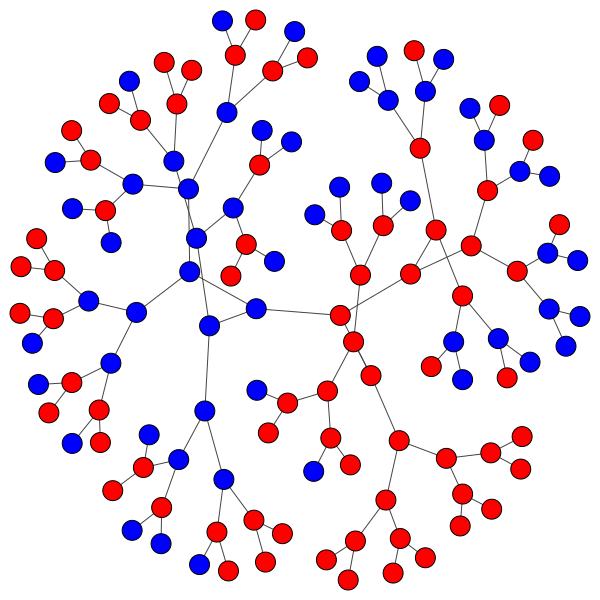

In [91]:
G.vs["color"] = ["blue" if attribution1[i] == 1 else "red" for i in range(n)]
out = igraph.plot(G)
#out.save("treeB")
out

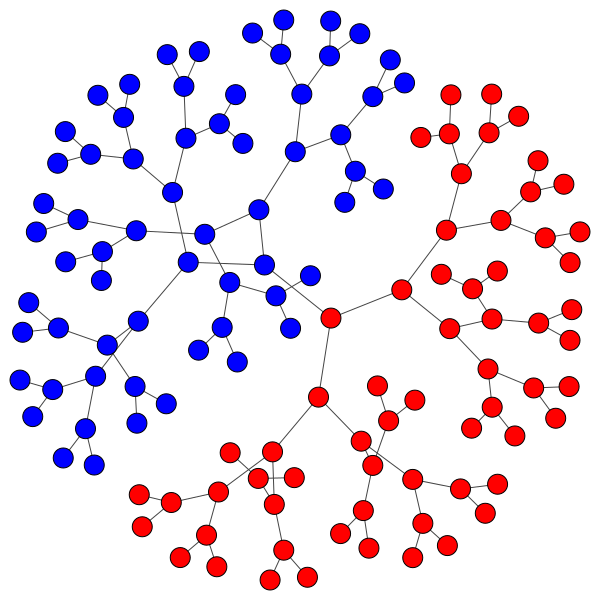

In [94]:
G.vs["color"] = ["blue" if attribution2[i] == 1 else "red" for i in range(n)]
out = igraph.plot(G)
#out.save("treeR.png")
out

In [98]:
B = computeFlow(tree)
R = reluctantAndNormalized(tree)[1]
w1 = scipy.sparse.linalg.eigs(B, k = 2, which = 'LR')
eigenval1 = w1[0]
eigenvec1 = w1[1]
indexSortedList1 = sorted([i for i in range(len(eigenval1))], key = lambda x : eigenval1[x])
w2 = scipy.sparse.linalg.eigs(R, k = 2, which = 'LR')
eigenval2 = w2[0]
eigenvec2 = w2[1]
indexSortedList2 = sorted([i for i in range(len(eigenval2))], key = lambda x : eigenval2[x])

eigv1 = eigenval1[indexSortedList1[1]]
eigv2 = eigenval2[indexSortedList2[1]]

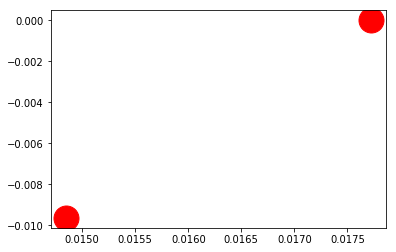

In [99]:
lReal = []
lIm = []
for elem in eigenval1:
    lReal.append(elem.real)
    lIm.append(elem.imag)
plt.plot(lReal, lIm, 'r.', markersize = 50)
plt.savefig("SpectrumTreeB")

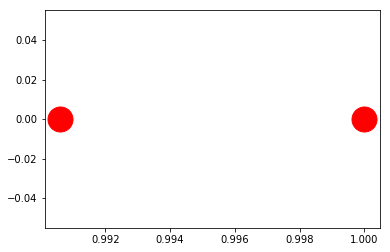

In [100]:
lReal = []
lIm = []
for elem in eigenval2:
    lReal.append(elem.real)
    lIm.append(elem.imag)
plt.plot(lReal, lIm, 'r.', markersize = 50)
plt.savefig("SpectrumTreeR")

## Real World Data sets

In [13]:
labelKarate = [-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1]
GKarate = nx.karate_club_graph()

In [14]:
GKarate.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

In [30]:
partitionB = bipartition(GKarate,"B")
partitionF = bipartition(GKarate,"F")
partitionR = bipartition(GKarate,"R")
partitionP = bipartition(GKarate,"P")

/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:120: ComplexWarning: Casting complex values to real discards the imaginary part


In [84]:
print(partitionB)
print(partitionF)
print(partitionR)
print(partitionP)

[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1]
[-1 -1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1]
[ 1  1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1]


In [31]:
partitionL = bipartition(GKarate,"L")

In [34]:
overlapGiven(labelKarate, partitionL)

0.47058823529411764

In [35]:
partitionL

array([-1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [36]:
B = computeBPrime(GKarate)
F = computeFlow(GKarate)
[R,P] = reluctantAndNormalized(GKarate)
A = scipy.sparse.csr_matrix(nx.adjacency_matrix(GKarate), dtype = 'd')

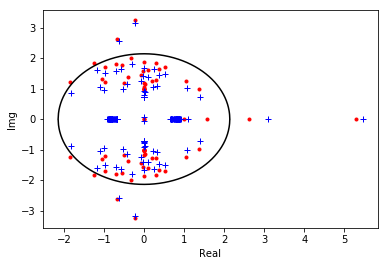

In [80]:
w, v = LA.eig(B)
w1, v1 = LA.eig(np.array(scipy.sparse.csr_matrix.todense(R)))
plotEigCom2(w,w1, 4.58824)

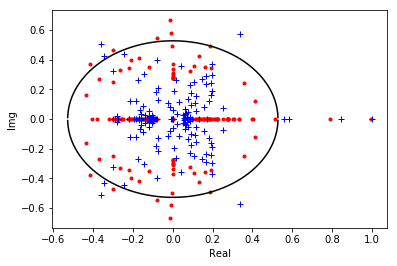

In [82]:
w, v = LA.eig(np.array(scipy.sparse.csr_matrix.todense(F)))
w1, v1 = LA.eig(np.array(scipy.sparse.csr_matrix.todense(P)))
plotEigCom2(w,w1, 1/3.58824)

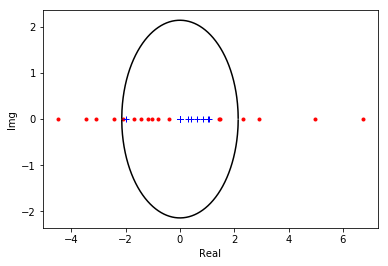

In [83]:
w, v = LA.eig(np.array(scipy.sparse.csr_matrix.todense(A)))
plotEigCom(w, 4.6)

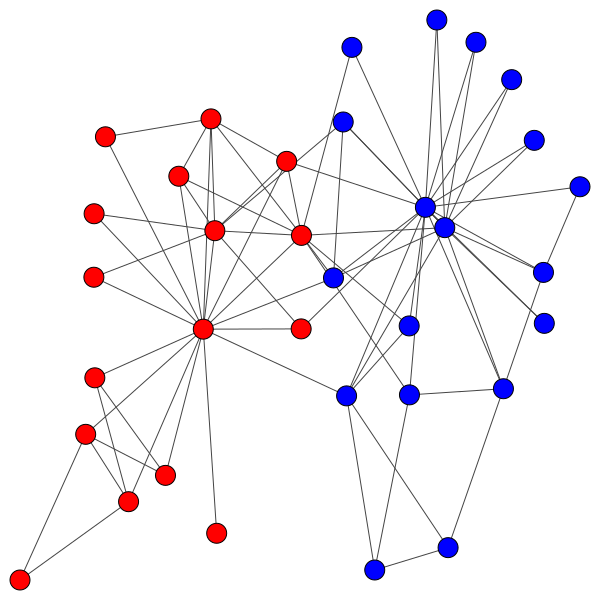

In [96]:
G = igraph.Graph.Adjacency(np.array(scipy.sparse.csr_matrix.todense(nx.adjacency_matrix(GKarate))).tolist())
G.to_undirected()
G.vs["color"] = ["blue" if partitionB[i] == 1 else "red" for i in range(34)]
out = igraph.plot(G)
out

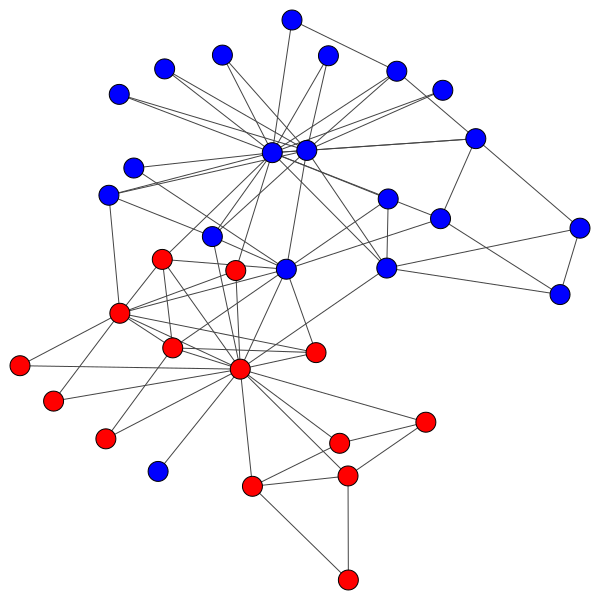

In [95]:
G.vs["color"] = ["blue" if partitionF[i] == 1 else "red" for i in range(34)]
out = igraph.plot(G)
out

In [6]:
Gdol = nx.read_gml("dolphins.gml")

In [23]:
print(nx.adjacency_matrix(Gdol))

  (0, 10)	1
  (0, 14)	1
  (0, 15)	1
  (0, 40)	1
  (0, 42)	1
  (0, 47)	1
  (1, 17)	1
  (1, 19)	1
  (1, 26)	1
  (1, 27)	1
  (1, 28)	1
  (1, 36)	1
  (1, 41)	1
  (1, 54)	1
  (2, 10)	1
  (2, 42)	1
  (2, 44)	1
  (2, 61)	1
  (3, 8)	1
  (3, 14)	1
  (3, 59)	1
  (4, 51)	1
  (5, 9)	1
  (5, 13)	1
  (5, 56)	1
  :	:
  (54, 41)	1
  (54, 57)	1
  (55, 15)	1
  (55, 51)	1
  (56, 5)	1
  (56, 6)	1
  (57, 5)	1
  (57, 6)	1
  (57, 9)	1
  (57, 13)	1
  (57, 17)	1
  (57, 39)	1
  (57, 41)	1
  (57, 48)	1
  (57, 54)	1
  (58, 38)	1
  (59, 3)	1
  (59, 8)	1
  (59, 15)	1
  (59, 36)	1
  (59, 45)	1
  (60, 32)	1
  (61, 2)	1
  (61, 37)	1
  (61, 53)	1


In [59]:
Gdol = nx.read_edgelist("edgeListPolBooks")
Gdol = nx.from_numpy_matrix(scipy.sparse.csr_matrix.toarray(nx.adjacency_matrix(Gdol)))

In [60]:
Gdol.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104))

In [61]:
partitionB = bipartition(Gdol,"B")
partitionF = bipartition(Gdol,"F")
partitionR = bipartition(Gdol,"R")
partitionP = bipartition(Gdol,"P")

/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:120: ComplexWarning: Casting complex values to real discards the imaginary part


In [62]:
print(partitionB)
print(partitionF)
print(partitionR)
print(partitionP)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1  1  1  1  1  1  1  1  1  1  1  1 

In [83]:
np.nonzero(np.array(partitionB) == np.array(partitionF))

(array([ 7, 32, 50, 80, 82, 83]),)

In [66]:
partitionL = bipartition(Gdol,"L")

In [67]:
B = computeBPrime(Gdol)
F = computeFlow(Gdol)
[R,P] = reluctantAndNormalized(Gdol)
A = scipy.sparse.csr_matrix(nx.adjacency_matrix(Gdol), dtype = 'd')

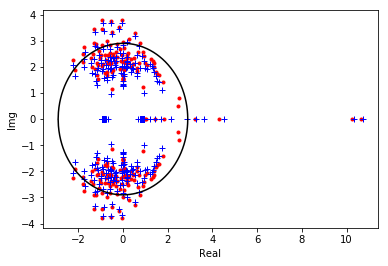

In [73]:
w, v = LA.eig(B)
w1, v1 = LA.eig(np.array(scipy.sparse.csr_matrix.todense(R)))
plotEigCom2(w,w1, 8.4)

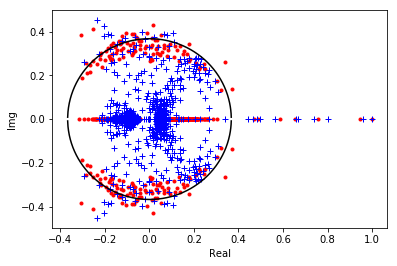

In [75]:
w, v = LA.eig(np.array(scipy.sparse.csr_matrix.todense(F)))
w1, v1 = LA.eig(np.array(scipy.sparse.csr_matrix.todense(P)))
plotEigCom2(w,w1, 1/7.4)

black


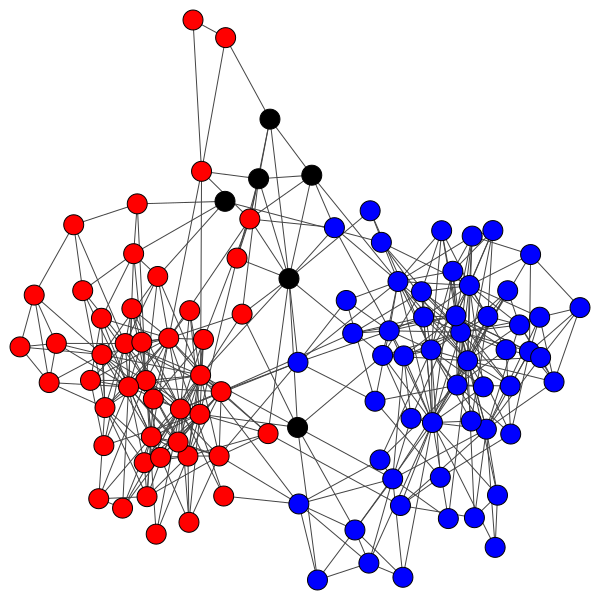

In [92]:
G = igraph.Graph.Adjacency(np.array(scipy.sparse.csr_matrix.todense(nx.adjacency_matrix(Gdol))).tolist())
G.to_undirected()
lcolor = ["blue" if partitionF[i] == -1 else "red" for i in range(105)]

for i in [7, 32, 50, 80, 82, 83]:
    lcolor[i] = "black"
G.vs["color"] = lcolor
print(G.vs["color"][7])
out = igraph.plot(G)
out.save("PolGrImPerf2.png")
out

In [ ]:
/home/pierre/Documents/CourseOxford/MiniProjectNetwork/polbooks.graph